# Finding Concentration Jacobian(1st Derivative)
What is the partial derivative of the Intensity at each SDD for concentration? Can we find a general solution and then extend it to both the maternal change and the fetal change.

## Using the Vector Approach
Using the same notations as [here](vector_approach.ipynb)
$$
log(I) = log(|G|) + log(|A(c)|) + log(cos(\angle GA(c))) \\  
\frac{\partial log(I)}{\partial c} =  \frac{\partial log(|A(c)|)}{\partial c} + \frac{\partial log(cos(\angle GA(c)))}{\partial c}
$$
Where, we can derive, $log(|A|) = \frac{1}{2}log(\frac{N}{2\epsilon c})$. Therefore, 
$$
\frac{\partial log(|A(c)|)}{\partial c} = \frac{1}{2} \frac{2\epsilon c}{N} * (-1) * \frac{N}{2\epsilon c^2} = -\frac{1}{2c}
$$

But, how can we express the partial cosine derivative term? My analysis suggests that it depends on the distribution of data itself and there should not be some analytical solution here


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from ipywidgets import interact
import ipywidgets as widgets
from tfo_sensitivity.data import load_raw
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from inverse_modelling_tfo.data import EQUIDISTANCE_DETECTOR_COUNT, EQUIDISTANCE_DETECTOR_PHOTON_COUNT

maternal_wall_thickness, uterus_thickness, wave_int = 12, 5, 1
raw_sim_data_path = load_raw(
    maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data['SDD'].unique()

In [66]:
MATERNAL_Hb = 12.
MATERNAL_SAT = 0.9
FETAL_SAT = 0.225
FETAL_Hb = 0.11
DELTA = 0.0001

all_dI = []
all_c = np.arange(0.1, 1.5, 0.1)
sdd_index = 12
SDD = all_sdd[sdd_index]


for c in all_c:
    modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
    
    modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
    modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)
    
    # modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb * (1 - DELTA), wave_int)
    # modified_mu_map[4] = get_mu_a(FETAL_SAT, c * (1 - DELTA), wave_int)
    modified_mu_map[4] = get_mu_a(FETAL_SAT, c - DELTA, wave_int)
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD]
    
    I1 = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath', 'L4 ppath']].to_numpy()
    for i in range(1, 5):
        I1[:, i - 1] = np.exp(-modified_mu_map[i] * I1[:, i - 1])
    I1 = np.prod(I1, axis=1)
    I1 = np.sum(I1)
    I1 /= EQUIDISTANCE_DETECTOR_COUNT[sdd_index]
    I1 /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT
    
    # modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb * (1 + DELTA), wave_int)
    # modified_mu_map[4] = get_mu_a(FETAL_SAT, c * (1 + DELTA), wave_int)
    modified_mu_map[4] = get_mu_a(FETAL_SAT, c + DELTA, wave_int)
    I2 = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath', 'L4 ppath']].to_numpy()
    for i in range(1, 5):
        I2[:, i - 1] = np.exp(-modified_mu_map[i] * I2[:, i - 1])
    I2 = np.prod(I2, axis=1)
    I2 = np.sum(I2)
    I2 /= EQUIDISTANCE_DETECTOR_COUNT[sdd_index]
    I2 /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT

    modified_mu_map[4] = get_mu_a(FETAL_SAT, c, wave_int)
    I0 = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath', 'L4 ppath']].to_numpy()
    for i in range(1, 5):
        I0[:, i - 1] = np.exp(-modified_mu_map[i] * I0[:, i - 1])
    I0 = np.prod(I0, axis=1)
    I0 = np.sum(I0)
    I0 /= EQUIDISTANCE_DETECTOR_COUNT[sdd_index]
    I0 /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT
    
    # dI = (I2 - I1) / (2 * DELTA * c)
    dI = (I1 - I2) / I0 / (2 * DELTA)
    # dI = (np.log(I1) - np.log(I2)) / I0 / (2 * DELTA)
    # dI = (np.log(I2) - np.log(I1)) / (2 * DELTA * c)
    all_dI.append(dI)


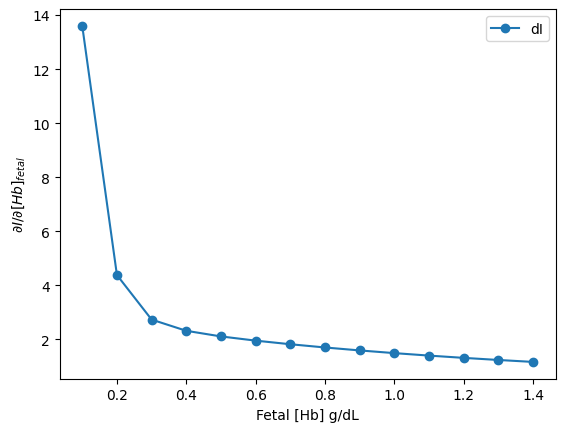

In [67]:
plt.figure()
dlogA = 1 / (2 * all_c) 
# plt.plot(all_c, np.abs(np.array(all_dI)), 'o')
plt.plot(all_c, all_dI, 'o-', label='dI')
# plt.plot(all_c, dlogA, 'o-', label='-1/(2c)')
# plt.plot(all_c, np.array(all_dI) - dlogA, 'o-', label='Difference')
plt.xlabel('Fetal [Hb] g/dL')
# plt.ylabel(r'$\partial log(I) / \partial [Hb]_{fetal} $')
plt.ylabel(r'$\partial I / \partial [Hb]_{fetal} $')
# plt.yscale('log')
plt.legend()

In [15]:
MATERNAL_Hb = 12.
MATERNAL_SAT = 0.9
FETAL_SAT = 0.225
FETAL_Hb = 0.11
DELTA = 0.005

all_dI = []

for sdd_index, sdd in enumerate(all_sdd):
    modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
    modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
    modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)
    
    modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb * (1 - DELTA), wave_int)
    # modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb * (1 - DELTA), wave_int)
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == sdd]
    I1 = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath', 'L4 ppath']].to_numpy()
    for i in range(1, 5):
        I1[:, i - 1] = np.exp(-modified_mu_map[i] * I1[:, i - 1])
    I1 = np.prod(I1, axis=1)
    I1 = np.sum(I1)
    I1 /= EQUIDISTANCE_DETECTOR_COUNT[sdd_index]
    I1 /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT
    
    modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb * (1 + DELTA), wave_int)
    # modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb * (1 + DELTA), wave_int)
    I2 = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath', 'L4 ppath']].to_numpy()
    for i in range(1, 5):
        I2[:, i - 1] = np.exp(-modified_mu_map[i] * I2[:, i - 1])
    I2 = np.prod(I2, axis=1)
    I2 = np.sum(I2)
    I2 /= EQUIDISTANCE_DETECTOR_COUNT[sdd_index]
    I2 /= EQUIDISTANCE_DETECTOR_PHOTON_COUNT
    
    dI = (np.log(I2) - np.log(I1)) / (2 * DELTA * FETAL_Hb)
    all_dI.append(dI)


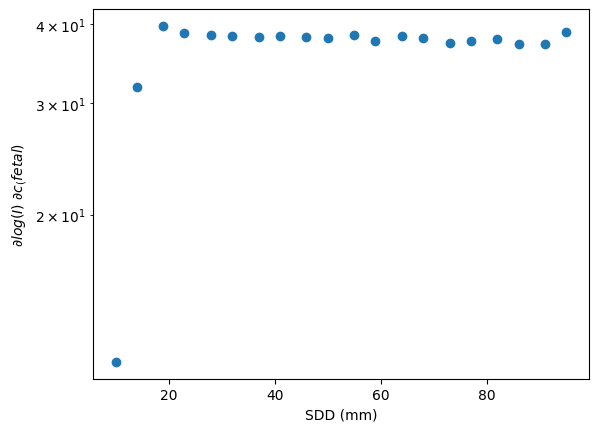

In [17]:
plt.figure()
plt.plot(all_sdd, np.abs(np.array(all_dI)), 'o')
# plt.plot(all_sdd, all_dI, 'o')
plt.xlabel('SDD (mm)')
plt.ylabel(r'$\partial log(I) \ \partial c_(fetal) $')
plt.yscale('log')

__Remarks__ : This plot is done for a constant c. The partial derivative of the first term(The $\frac{\partial log(|A(c)|)}{\partial c}$) does not have any term related to SDD. According to that part, the derivative is constant. But clearly, the derivative is not. So this would be the effect of the second term. 